In [54]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from time import time
import plotting
import itertools

## 初始化背包

In [2]:
item = pd.DataFrame(data=[[1, 1], [6, 2], [18, 5], [22, 6], [28, 7]], columns=['Value', 'Weight'])

actions = list(range(len(item))) # 动作, 每一个物体是一个动作
limit_W = 11 # 背包重量的限制
gamma = 0.9

In [3]:
item

,Value,Weight
0,1,1
1,6,2
2,18,5
3,22,6
4,28,7


## Q-Learning部分

### 策略的定义

- $\mu$, 定义$\epsilon$-greedy的策略;
- $\pi$, 定义greedy的策略;

In [150]:
def mu_policy(Q, epsilon, nA, observation, actions):
    """
    这是一个epsilon-greedy的策略, 返回每一个动作执行的概率, nA为动作的个数
    其中: 
    - Q是q table, 为dataframe的格式;
    - nA是所有动作的个数
    """
    actionsList = list(set(actions).difference(set(observation))) # 可以挑选的动作
    # 看到这个state之后, 采取不同action获得的累计奖励
    action_values = Q.loc[str(observation), :]
    # 使用获得奖励最大的那个动作
    greedy_action = action_values.idxmax()
    # 是的每个动作都有出现的可能性
    probabilities = np.zeros(nA)
    for i in actionsList:
        probabilities[i] = 1/len(actionsList) * epsilon
    probabilities[greedy_action] = probabilities[greedy_action] + (1 - epsilon)
    return probabilities

In [129]:
def pi_policy(Q, observation):
    """
    这是greedy policy, 每次选择最优的动作.
    其中: 
    - Q是q table, 为dataframe的格式;
    """
    action_values = Q.loc[str(observation), :]
    best_action = action_values.idxmax() # 选择最优的动作
    return np.eye(len(action_values))[best_action] # 返回的是两个动作出现的概率


### 模型环境

- 返回reward, 是否结束, next_state

In [115]:
def envReward(action, knapsack):
    """返回下一步的state, reward和done
    """
    limit_W = 11
    knapsack_ = knapsack + [action] # 得到新的背包里的东西, 现在是[2,3], 向里面增加物品[1], 得到新的状态[1,2,3]
    knapsack_.sort()

    knapsack_W = np.sum([item['Weight'][i] for i in knapsack_]) # 计算当前包内物品的总和
    if knapsack_W > limit_W:
        r = -10
        done = True
    else:
        r = item['Value'][action]
        done = False
    return r, knapsack_, done

### Q Table开始更新

In [116]:
def check_state(Q, knapsack, actions):
    """检查状态knapsack是否在q-table中, 没有则进行添加
    """
    if str(knapsack) not in Q.index: # knapsack表示状态, 例如现在包里有[1,2]
        # append new state to q table
        q_table_new = pd.Series([np.NAN]*len(actions), index=Q.columns, name=str(knapsack))
        # 下面是将能使用的状态设置为0, 不能使用的设置为NaN (这个很重要)
        for i in list(set(actions).difference(set(knapsack))):
            q_table_new[i] = 0
        return Q.append(q_table_new)
    else:
        return Q

In [169]:
def qLearning(actions, num_episodes, discount_factor=1.0, alpha=0.7, epsilon=0.2):
    # 环境中所有动作的数量
    nA = len(actions)

    # 初始化Q表
    Q = pd.DataFrame(columns=actions)
    
    # 记录reward和总长度的变化
    stats = plotting.EpisodeStats(
        episode_lengths=np.zeros(num_episodes+1),
        episode_rewards=np.zeros(num_episodes+1)) 
    

    for i_episode in range(1, num_episodes + 1):
        # 开始一轮游戏
        knapsack = [] # 开始的时候背包是空的
        Q = check_state(Q, knapsack, actions)
        action = np.random.choice(nA, p=mu_policy(Q, epsilon, nA, knapsack, actions)) # 从实际执行的policy, 选择action
        for t in itertools.count():
            reward, next_knapsack, done = envReward(action, knapsack) # 执行action, 返回reward和下一步的状态
            Q = check_state(Q, next_knapsack, actions)

            next_action = np.random.choice(nA, p=mu_policy(Q, epsilon, nA, next_knapsack, actions)) # 选择下一步的动作
            # 更新Q
            Q.loc[str(knapsack), action] = Q.loc[str(knapsack), action] + alpha*(reward + discount_factor*Q.loc[str(next_knapsack), :].max() - Q.loc[str(knapsack), action])

            # 计算统计数据(带有探索的策略)
            stats.episode_rewards[i_episode] += reward # 计算累计奖励
            stats.episode_lengths[i_episode] = t # 查看每一轮的时间

            if done:
                break
            
            if t > 10:
                break

            knapsack = next_knapsack
            action = next_action

        if i_episode % 50 == 0:
            # 打印
            print("\rEpisode {}/{}. | ".format(i_episode, num_episodes), end="")
    
    return Q, stats

### 进行训练

In [170]:
Q, stats = qLearning(actions, num_episodes=1000, discount_factor=0.9, alpha=0.3, epsilon=0.1)

Episode 1000/1000. | 

In [171]:
Q

,0,1,2,3,4
[],16.324878,23.331530,29.700000,23.058438,26.920000
[0],NaN,19.572150,0.000000,7.315684,12.913523
"[0, 1]",NaN,NaN,9.329467,0.000000,17.904709
"[0, 1, 2]",NaN,NaN,NaN,-9.998084,-9.998084
"[0, 1, 2, 3]",NaN,NaN,NaN,NaN,0.000000
"[0, 1, 2, 4]",NaN,NaN,NaN,0.000000,NaN
[4],-1.576235,-1.200000,-6.570000,-9.176457,NaN
"[0, 4]",NaN,-2.986360,-3.000000,-5.100000,NaN
"[0, 1, 4]",NaN,NaN,-10.000000,-10.000000,NaN
"[0, 1, 3, 4]",NaN,NaN,0.000000,NaN,NaN


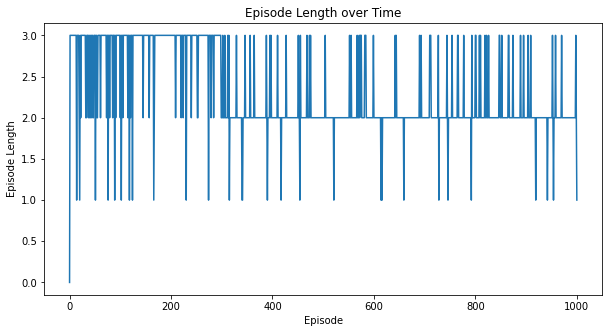

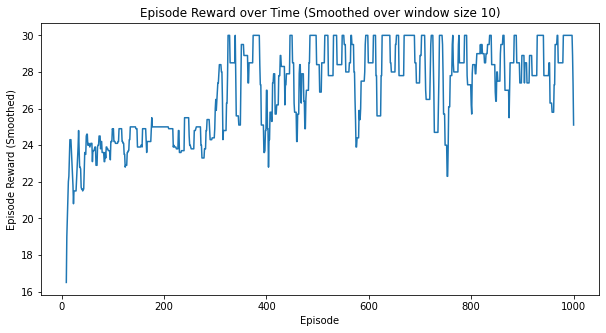

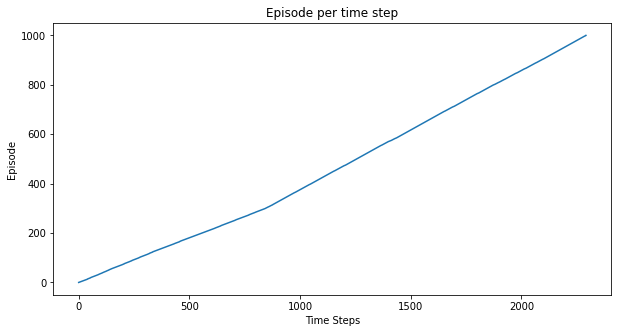

(<Figure size 720x360 with 1 Axes>,
 <Figure size 720x360 with 1 Axes>,
 <Figure size 720x360 with 1 Axes>)

In [172]:
# 因为策略会有尝试, 所以reward看起来不稳定
plotting.plot_episode_stats(stats)

In [162]:
# 查看最终结果
actionsList = []
knapsack = [] # 开始的时候背包是空的
nA = len(actions)

action = np.random.choice(nA, p=pi_policy(Q, knapsack)) # 从实际执行的policy, 选择action

for t in itertools.count():
    actionsList.append(action)
    reward, next_knapsack, done = envReward(action, knapsack) # 执行action, 返回reward和下一步的状态
    next_action = np.random.choice(nA, p=pi_policy(Q, next_knapsack)) # 选择下一步的动作
    if done:
        actionsList.pop()
        break
    else:
        action = next_action
        knapsack = next_knapsack

In [163]:
actionsList

[3, 2]

## 下面是知乎上的代码

In [173]:
class RLforKnapsack():
    def __init__(self, limit_W, actions):
        self.limit_W = limit_W  # maximal weight
        self.epsilon = 0.9  # e-greedy algorithm
        self.gamma = 0.9  # reward decay (衰减因子)
        self.alpha = 0.8  # learning_rate
        self.actions = actions
        self.q_table = pd.DataFrame(columns=actions)
        self.done = False

    def check_state(self, knapsack):
        """检查状态knapsack是否在q-table中, 没有则进行添加
        """
        if str(knapsack) not in self.q_table.index: # knapsack表示状态, 例如现在包里有[1,2]
            # append new state to q table
            q_table_new = pd.Series([np.NAN]*len(self.actions),
                                    index=self.q_table.columns,
                                    name=str(knapsack))
            # 下面是将能使用的状态设置为0, 不能使用的设置为NaN (这个很重要)
            for i in list(set(self.actions).difference(set(knapsack))):
                q_table_new[i] = 0
            self.q_table = self.q_table.append(q_table_new)

    def choose_action(self, knapsack):
        """epsilon-greedy策略, 用来探索
        """
        self.check_state(knapsack) # 检查这个状态是否在q table中
        state_action = self.q_table.loc[str(knapsack), :] # 得到这个state每一个action的value
        # random state_action in case there are two or more maximum
        # state_action = state_action.reindex(np.random.permutation(state_action.index)) # 得到动作序列(这里为什么需要reindex), 而且为什么这样都是可以收敛的
        if np.random.uniform() < self.epsilon:
            # choose best action
            action = state_action.idxmax()  # the first maximun
        else:
            # choose random action
            action = np.random.choice(list(set(self.actions).difference(set(knapsack)))) # 从剩下的里面随机挑(不能重选, 这个很重要)
        return action

    def greedy_action(self, knapsack):
        """greedy策略, 用来实际执行, choose best action.
        """
        state_action = self.q_table.loc[str(knapsack), :]
        # state_action = state_action.reindex(np.random.permutation(state_action.index))
        action = state_action.idxmax() # 返回最大值对应的id
        return action

    def take_action(self, knapsack, action):
        """选择物品, 并添加到q_table中去
        """
        knapsack_ = knapsack + [action]
        knapsack_.sort()
        self.check_state(knapsack_) # 向q-table里面添加
        return knapsack_

    def rewardWithPenalty(self, knapsack_, action):
        """reward函数, 有constraint的作用, 通过reward来限制包内的物品重量
        """
        knapsack_W = np.sum([item['Weight'][i] for i in knapsack_]) # 计算包内物品的总和
        if knapsack_W > self.limit_W:
            r = -10
            self.done = True
        else:
            r = item['Value'][action]
        return r

    def update_qvalue(self, knapsack, knapsack_, action):
        """knapsack表示当前的state, knapsack_表示下一个state
        """
        self.done = False
        reward = self.rewardWithPenalty(knapsack_, action) # 获得对应的reward
        q_predict = self.q_table.loc[str(knapsack), action] # 获得q值
        if len(knapsack) != len(self.actions): # 判断是否所有的物品都已经用完
            q_target = reward + self.gamma * self.q_table.loc[str(knapsack_), :].max()
        else:
            q_target = reward  # no item can be added
        self.q_table.loc[str(knapsack), action] += self.alpha * (q_target - q_predict)
        return self.q_table, self.done

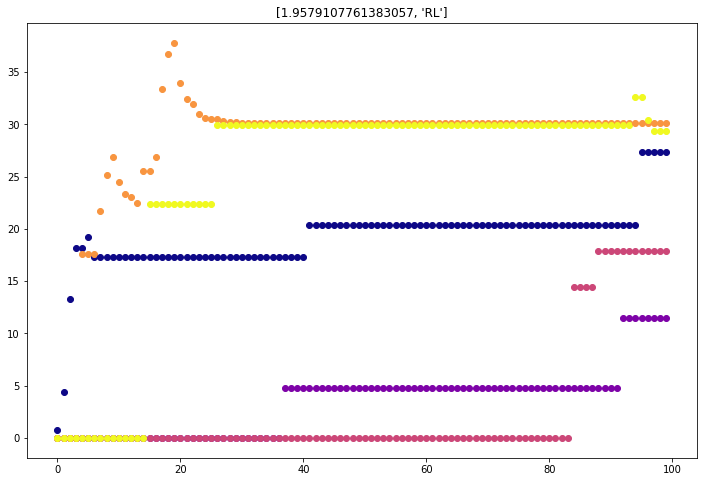

In [188]:
t1 = time()

# 进行可视化
cmap = plt.get_cmap('plasma',5) # 数字与颜色的转换

plt.close('all')
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(1,1,1)


RL = RLforKnapsack(limit_W=11, actions=actions)
for episode in range(100):
    knapsack = []
    for step in range(5):
        action = RL.choose_action(knapsack)
        knapsack_ = RL.take_action(knapsack, action)
        q_table_RL, done = RL.update_qvalue(knapsack, knapsack_, action)
        knapsack = knapsack_
        if done:
            break
    # 初始状态, 采取不同action之后会获得的累计reward
    ax.scatter(episode, q_table_RL.iloc[0, 0], color=cmap(0))
    ax.scatter(episode, q_table_RL.iloc[0, 1], color=cmap(1))
    ax.scatter(episode, q_table_RL.iloc[0, 2], color=cmap(2))
    ax.scatter(episode, q_table_RL.iloc[0, 3], color=cmap(3))
    ax.scatter(episode, q_table_RL.iloc[0, 4], color=cmap(4))

t2 = time()
plt.title([t2-t1, 'RL'])
plt.show()

In [187]:
q_table_RL

,0,1,2,3,4
[],13.690209,4.800000,14.400000,21.696000,26.920000
[0],NaN,14.100066,0.000000,0.000000,0.000000
"[0, 1]",NaN,NaN,9.000009,0.000000,0.000000
"[0, 1, 2]",NaN,NaN,NaN,-9.999999,-9.999995
"[0, 1, 2, 3]",NaN,NaN,NaN,NaN,0.000000
"[0, 1, 2, 4]",NaN,NaN,NaN,0.000000,NaN
[4],-1.688458,-1.200000,-9.984000,-9.600000,NaN
"[0, 4]",NaN,-2.996478,-9.600000,-8.000000,NaN
"[0, 1, 4]",NaN,NaN,-10.000000,-10.000000,NaN
"[0, 1, 3, 4]",NaN,NaN,0.000000,NaN,NaN


In [ ]:

# %% Policy based on q table
knapsack = []
# %%
action = RL.greedy_action(knapsack)
knapsack_ = RL.take_action(knapsack, action)
knapsack = knapsack_
np.sum([item['Weight'][i] for i in knapsack_])
print(np.sum([item['Weight'][i] for i in knapsack_]))
# %%